<a href="https://colab.research.google.com/github/Samyad-JAIN/KHGU/blob/main/samyad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samyadjainm","key":"dd5db2c4ce0eedddec17c052b9a989a0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d shaikhshoeb/tomoto-plant-disease


Dataset URL: https://www.kaggle.com/datasets/shaikhshoeb/tomoto-plant-disease
License(s): unknown
 72% 127M/175M [00:00<00:00, 1.33GB/s]
100% 175M/175M [00:00<00:00, 1.30GB/s]


In [ ]:
!unzip tomoto-plant-disease.zip -d dataset/


Streaming output truncated to the last 5000 lines.
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/0751ddb1-c3ee-46ee-bee1-46c24c567dc2___Matt.S_CG 6116.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/07679a50-9d8d-4612-80f4-464785781d56___JR_Sept.L.S 2727.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/076b6071-1ce2-4ed1-9dcf-077dcd7640e4___JR_Sept.L.S 2468.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/07a4190c-b0c0-4e03-9ad5-474938c837d2___Matt.S_CG 1242.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/07dd57ec-cbf0-4fc1-b680-6b3226da51e4___JR_Sept.L.S 8524.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/07e5a836-f1d6-4fc3-8847-09c8f9c368ec___Matt.S_CG 6089.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/0806cabf-f026-43bd-a508-0e8e5a185341___Matt.S_CG 1266.JPG  
  inflating: dataset/plant disease/Tomato_Septoria_leaf_spot/08233234-a3af-4040-8814-eb13f89802d

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('/content/dataset/plant disease',output="dataset",seed=1337,ratio=(.8, 0.1,0.1))

Copying files: 11026 files [00:01, 6861.20 files/s]


DATA PREPROCESSING


In [ ]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8817 files belonging to 7 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dir = "/content/dataset/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1100 files belonging to 7 classes.
Found 1109 files belonging to 7 classes.


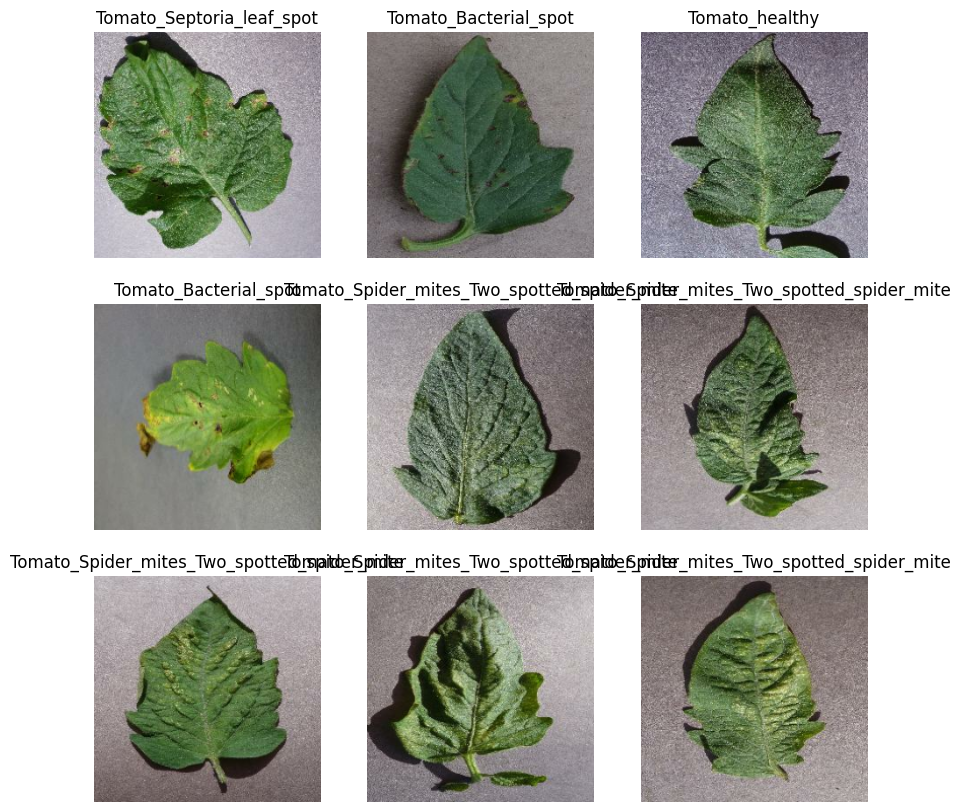

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_healthy']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

Create the base model from the pre-trained convnets


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1792)


Feature extraction


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        12,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,686,374 (67.47 MB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
len(model.trainable_variables)

2

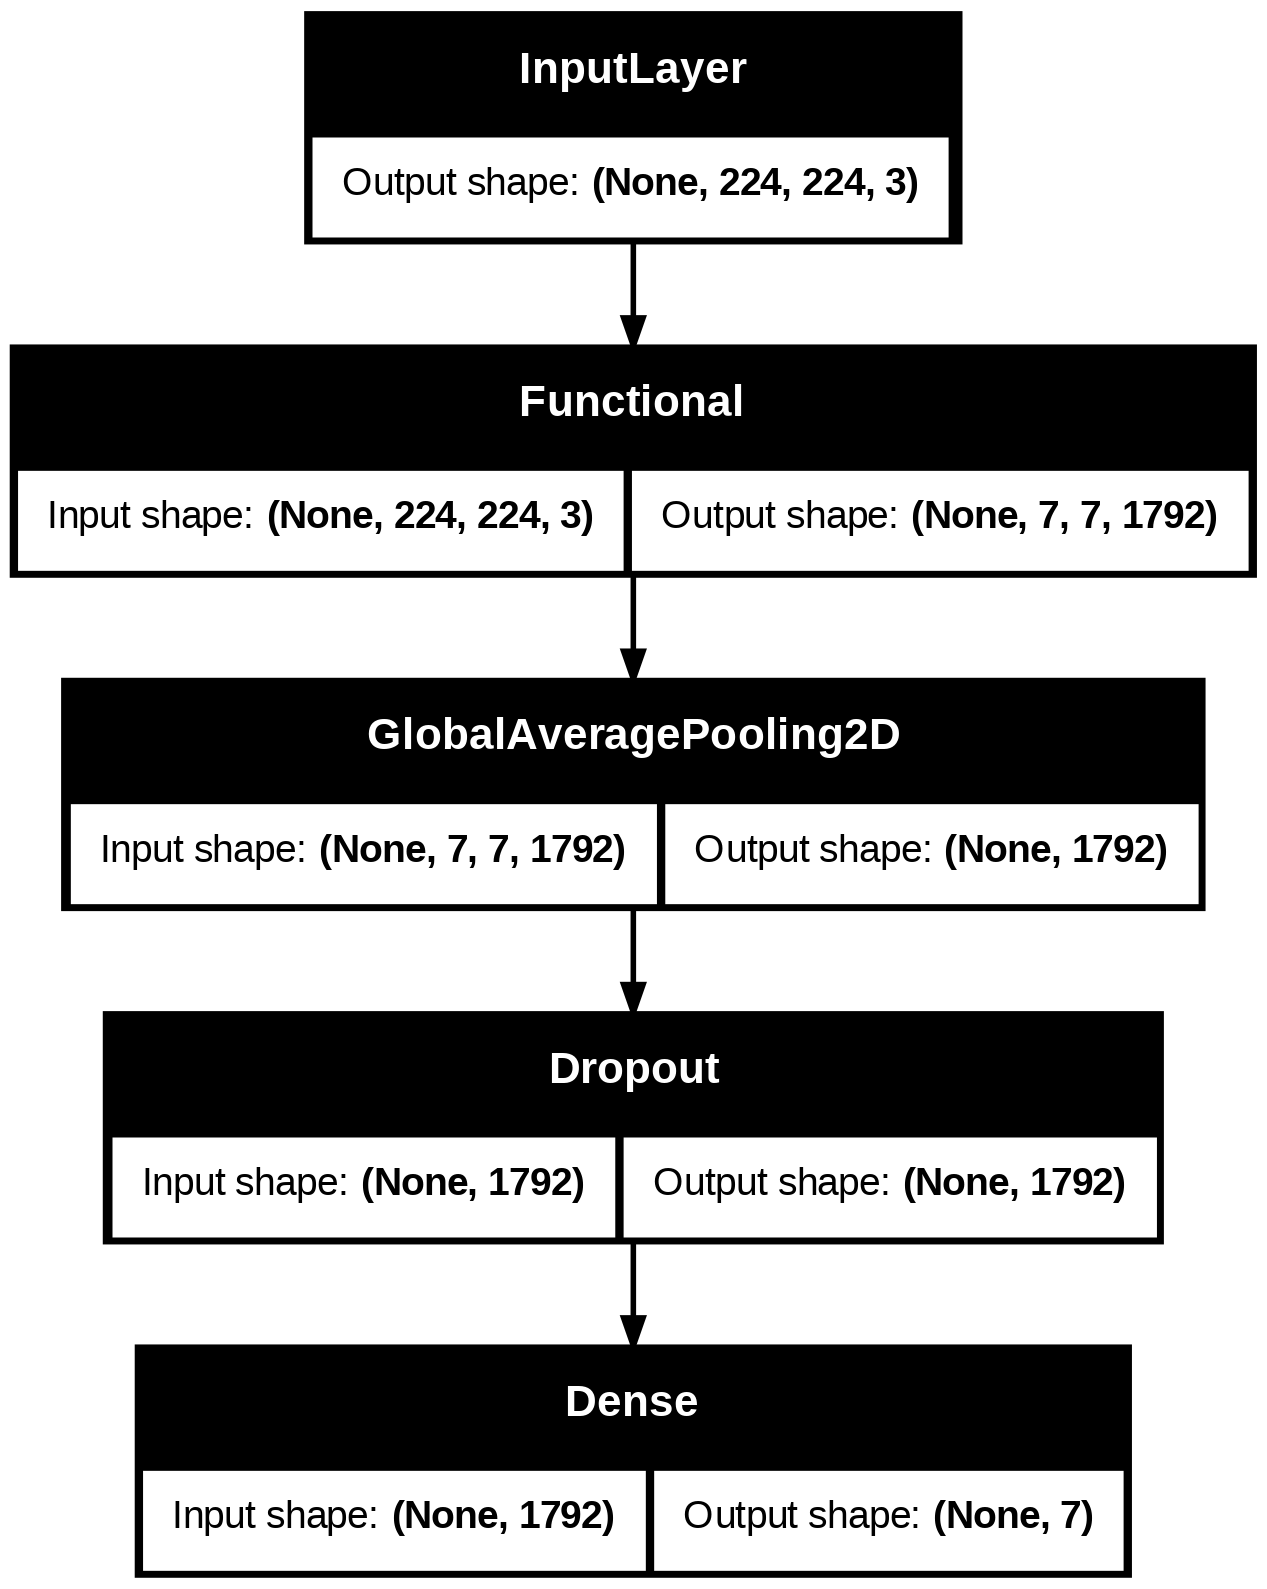

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9153 - loss: 0.2580


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.25
initial accuracy: 0.92


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - accuracy: 0.9110 - loss: 0.2949 - val_accuracy: 0.9327 - val_loss: 0.2328
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - accuracy: 0.9128 - loss: 0.2815 - val_accuracy: 0.9273 - val_loss: 0.2171
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - accuracy: 0.9156 - loss: 0.2616 - val_accuracy: 0.9273 - val_loss: 0.2159
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - accuracy: 0.9175 - loss: 0.2530 - val_accuracy: 0.9382 - val_loss: 0.2036
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - accuracy: 0.9229 - loss: 0.2429 - val_accuracy: 0.9400 - val_loss: 0.1974
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - accuracy: 0.9244 - loss: 0.2410 - val_accuracy: 0.9427 - val_loss: 0.1830
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - accuracy: 0.9274 - loss: 0.2240 - val_accuracy: 0.9473 - val_loss: 0.1787
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - accuracy: 0.9258 - loss: 0

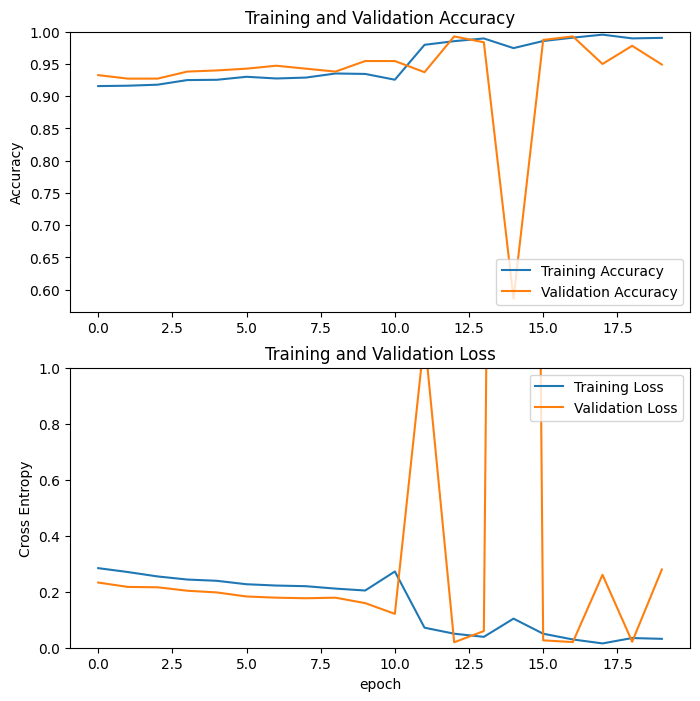

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fine tuning


In [49]:
base_model.trainable = True

In [50]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [52]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        12,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,686,374 (67.47 MB)

 Trainable params: 17,474,407 (66.66 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [53]:
len(model.trainable_variables)

333

In [54]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 269s 554ms/step - accuracy: 0.9786 - loss: 0.0736 - val_accuracy: 0.9682 - val_loss: 0.0953
Epoch 12/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 280ms/step - accuracy: 0.9884 - loss: 0.0380 - val_accuracy: 0.9382 - val_loss: 0.8081
Epoch 13/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 278ms/step - accuracy: 0.9909 - loss: 0.0347 - val_accuracy: 0.9318 - val_loss: 0.2380
Epoch 14/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 278ms/step - accuracy: 0.9911 - loss: 0.0365 - val_accuracy: 0.9927 - val_loss: 0.0274
Epoch 15/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 277ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9936 - val_loss: 0.0183
Epoch 16/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 76s 276ms/step - accuracy: 0.9913 - loss: 0.0265 - val_accuracy: 0.9927 - val_loss: 0.0268
Epoch 17/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 76s 276ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.9918 - val_loss: 0.0386
Epoch 18/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 278ms/step - accuracy: 0.9923 

In [55]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

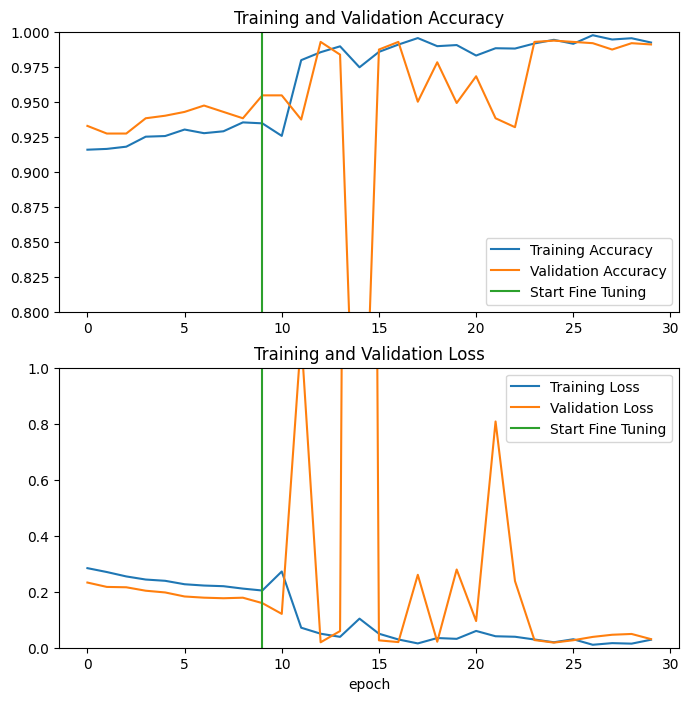

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9944 - loss: 0.0216
Test accuracy : 0.9927862882614136


Predictions:
 [4 6 0 6 0 4 3 6 2 2 0 5 5 4 6 6 5 5 5 0 6 0 5 4 0 4 4 5 0 1 0 0]
Labels:
 [4 6 0 6 0 4 3 6 2 2 0 5 5 4 6 6 5 5 5 0 6 0 5 4 0 4 4 5 0 1 0 0]


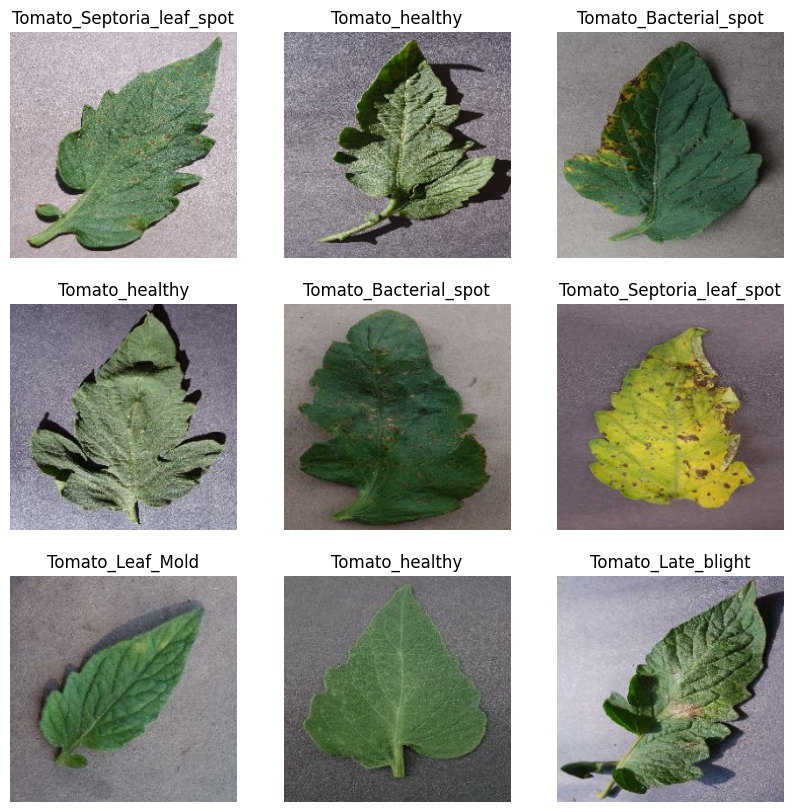

In [58]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")